In [1]:
import sys
sys.path.append("/Users/savard/PLUTO/pluto_playtime/plotting_analysis/")
sys.path.append("/Users/savard/PLUTO/")
import pyPLUTO as pypl
import pyPLUTO.pload as pp
import pandas as pd
from pyplutplot import *
wdir = '/pluto_playtime/data_storage/' #set up working directory where data is stored
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

choose which timestep to use

In [2]:
def tstep_to_days(t,dbl_step):
    """converts simulation steps into days.
    assumes a fixed simulation time unit writing a step every multiple of dbl_step
    """
    T_SIM_YEARS = 1.05*10**(-3)
    d = t*T_SIM_YEARS*365*dbl_step
    return d

def days_to_tstep(days, dbl_step):
    T_SIM_YEARS = 1.05*10**(-3)
    t = days/(T_SIM_YEARS*365*dbl_step)
    return t

def gamma_to_beta(gamma):
    beta = (1.-(gamma**-2))**0.5
    return beta

def beta_to_gamma(beta):
    gamma = 1./((1.-beta**2)**0.5)
    return gamma

def theta_from_beta(beta):
    theta = np.arccos(0.4/beta)*180/np.pi
    return theta

Load in data from current simulation at given timestep

In [56]:
image_timestep = 1

In [57]:
kappa = 0.1 #fraction of pressure contribution to luminosity
gamma = 2.0
system_name = 'ri0.001_rb0.02_lz2'
save_or_load = 'load'
data_dir = '/pluto_playtime/data_storage/'+system_name+'/' #set up working directory where data is stored
results_folder = '/Users/savard/PLUTO/pluto_playtime/plotting_analysis/sim_results/eht_scaled_sims'
results_folder_sim = '/Users/savard/PLUTO/pluto_playtime/plotting_analysis/sim_results/{}'.format(system_name)
D = load_data_obj(data_dir,image_timestep,data_type='flt')

#to account for efficiency of pressure to luminosity conversion 
distance_in_pc = 2960
angle_degrees = theta_from_beta(gamma_to_beta(gamma))
viewing_angle = (2*np.pi)/360 *angle_degrees
alpha= -0.507 #is this ok? already assumed for the luminosity conversion
P_sim = 1.503*10**(-4) #kg m^-1 s^2
L_sim = 1*10**9  #13 #m
nu_observe = (86.0 * 1e9)#(1.28* 1e9) #1.28 GHz (Bright2020)
eta=0.75
exponent = (3-alpha)/2
p = (4*exponent) - 5 #2.01


data type: flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/rho.0001.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/vx1.0001.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/vx2.0001.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/vx3.0001.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/prs.0001.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/tr1.0001.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/tr2.0001.flt


In [58]:
file_disp = 'disp_array'+str(system_name)
init_offset = 200
d_vals = load_list(results_folder_sim,file_disp)+init_offset

plot the timestep to check its the right one

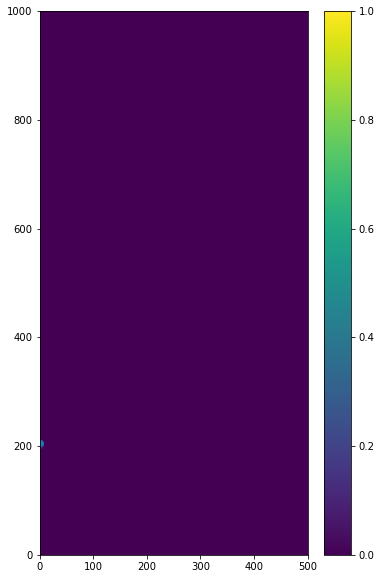

In [59]:
fig = plt.figure(figsize=[6,10])
#psuedo emissivity

v = D.tr1*((kappa*D.prs)**exponent)
x1 = D.x1
x2 = D.x2
plt.pcolormesh(x1,x2,v.T,shading='auto')
plt.scatter(0,d_vals[image_timestep])
#plt.pcolormesh(-ax1,ax2,var.T,shading='auto')
plt.colorbar()

now crop the image such that we dont have to integrate/interpolate too far -- want to detect the last relevant pixels

In [60]:
plt.close()
del fig

In [61]:
##find top limit

crop_traditional = True

if crop_traditional:
    is_zero = True #want this to turn false before true again 
    stop_index_top = 0
    for index, xrow in enumerate(v.T):
        if np.any(xrow):
            is_zero = False
        if not np.any(xrow) and not is_zero:
            stop_index_top = index
            break


    ### find bottom limit

    detection_limit = 1e-10

    is_zero = True #want this to turn false before true again 
    stop_index_bottom = 0
    for index, xrow in enumerate(v.T):
        if np.any(xrow):
            if np.max(xrow)>detection_limit:
                is_zero = False
                stop_index_bottom = index
                print(xrow)
                break

    #### find side limit

    detection_limit = 1e-10

    is_zero = True #want this to turn false before true again 
    stop_index_side = 0
    for index, yrow in reversed(list(enumerate(v))):
        if np.any(yrow):
            if np.max(yrow)>detection_limit:
                is_zero = False
                stop_index_side = index
                break

    buffer_size = 100
    minimum_size = 1300

    stop_index_top = stop_index_top + buffer_size
    stop_index_bottom = stop_index_bottom - buffer_size
    stop_index_side = stop_index_side + buffer_size


    vdiff = stop_index_top-stop_index_bottom
    if vdiff<minimum_size:
        print('ht minimum vertical size: resorting to default size')
        stop_index_bottom = stop_index_bottom+(int(vdiff/2))-(int(minimum_size/2))
        stop_index_top = stop_index_top-(int(vdiff/2))+(int(minimum_size/2))

    if stop_index_side<int(minimum_size/2):
        print("hit minimum lateral size: resorting to default size")
        stop_index_side = int(minimum_size/2)


    print(stop_index_top)
    print(stop_index_bottom)
    print(stop_index_side)

[1.3716731e-10 8.3983404e-11 4.0970314e-11 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
ht minimum vertical size: resorting to default size
hit minimum lateral size: resorting to default size
1873
573
650


Alternative: minimum size for all images but centered on the emission centroid

In [62]:
crop = True
if crop:
    stop_index_side = 650
    minimum_size = 1300
    stop_index_bottom = (int(d_vals[image_timestep])*6-int(minimum_size/2))
    stop_index_top = int(d_vals[image_timestep])*6+int(minimum_size/2)
    stop_index_bottom

resize variables

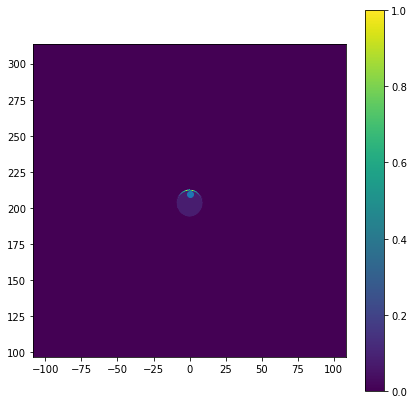

In [63]:
if crop:
    fig = plt.figure(figsize=[7,7])
    #psuedo emissivity
    em = ((D.tr1*((kappa*D.prs)**exponent))[:stop_index_side].T[stop_index_bottom:stop_index_top]).T #psuedo emissivity, 2D array 
    ax1 = D.x1[:stop_index_side]
    ax2 = D.x2[stop_index_bottom:stop_index_top]
    plt.pcolormesh(ax1,ax2,em.T,shading='auto')
    plt.pcolormesh(-ax1,ax2,em.T,shading='auto')
    plt.scatter(0,d_vals[image_timestep+1])

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    #plt.pcolormesh(-ax1,ax2,var.T,shading='auto')
    plt.colorbar()
else:
    em = (D.tr1*((kappa*D.prs)**exponent)).T #psuedo emissivity, 2D array 
    ax1 = D.x1
    ax2 = D.x2

In [46]:
int(d_vals[image_timestep])

572

In [12]:
len(ax2)

1300

In [35]:
plt.close()
del fig

Turn 2D cylindrical slice into 3D cartesian:

In [36]:
r = ax1 #r, 160 vals
z = ax2 #z, 1600 vals
theta = np.linspace(0,np.pi/2,130) #create some theta to wrap it around pi/2, arbitrary number of steps for now
#R, Z, THETA = np.meshgrid(r,z,theta) #all have the same shape (1600,160,320)
#EMIS = np.dstack([values]*len(theta)) #stack 2D emissivity as the same slice for every theta, cylindrically symmetric

add in doppler boosting factor to

In [37]:
def angle_to_boost(angle,beta):
    gamma = (1-(beta**2))**(-0.5)
    #change minus sign for approaching (-) or receding (+) jet
    delta = (gamma**(-1))*(1.0-beta*np.cos(angle))**(-1)
    return delta

def doppler_boost_lum(beta,viewing_angle,alpha,lum):
    delta = angle_to_boost(viewing_angle,beta)
    boosted_lum = lum*(delta**(2-alpha))
    return boosted_lum

if crop:
    beta = (D.vx2[:stop_index_side].T[stop_index_bottom:stop_index_top]).T
else:
    beta = D.vx2
values = doppler_boost_lum(beta,viewing_angle,alpha,em)


In [38]:
np.shape(values)

(650, 1300)

In [39]:
np.shape(ax1)

(650,)

In [40]:
def cyl_to_cart(r,z,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = z
    return x, y, z

In [41]:
#iteration vars
theta_len = len(theta)
z_len = len(z)
r_len = len(r)

In [42]:
# creating long 2D arrays which correspond to each point in the frame -> ordered by constant z 
rr = []
zz = []
tt = []
ll = []

for i in range(z_len):
    #constant z iteration
    z_ordered = []
    r_ordered = []
    l_ordered = []
    theta_ordered = []
    for j in range(r_len):
        #constant r iteration with all theta
        arr_z = np.repeat(z[i],theta_len).tolist()
        arr_r = np.repeat(r[j],theta_len).tolist()
        arr_l = np.repeat(values[j][i],theta_len).tolist()
        r_ordered.append(arr_r) # r at i (const in j loop)
        z_ordered.append(arr_z) # z at j (iterating through const r)
        theta_ordered.append(theta) # for all theta
        l_ordered.append(arr_l)
    rr.append(np.asarray(r_ordered).flatten())
    zz.append(np.asarray(z_ordered).flatten())
    ll.append(np.asarray(l_ordered).flatten())
    tt.append(np.asarray(theta_ordered).flatten())

In [43]:
#convert to cartesian:
x_cart, y_cart, z_cart = cyl_to_cart(rr, zz, tt)

In [44]:
z_ordered = []
#x_ordered = []
#y_ordered = []
#l_ordered = []
num_z = len(ax2)
num_xtheta = len(ax1)*len(theta)

for i in range(num_z):
    z_ = z_cart[(0+(num_xtheta*i)):(0+(num_xtheta*(i+1)))]
    z_ordered.append(z_)
    #x_ = x_cart[(0+(num_xtheta*i)):(0+(num_xtheta*(i+1)))]
    #x_ordered.append(x_)
    #y_ = y_cart[(0+(num_xtheta*i)):(0+(num_xtheta*(i+1)))]
    #y_ordered.append(y_)
    #l_ = ll[(0+(num_xtheta*i)):(0+(num_xtheta*(i+1)))]
    #l_ordered.append(l_)


Text(0.5, 1.0, 'original cylindrical grid')

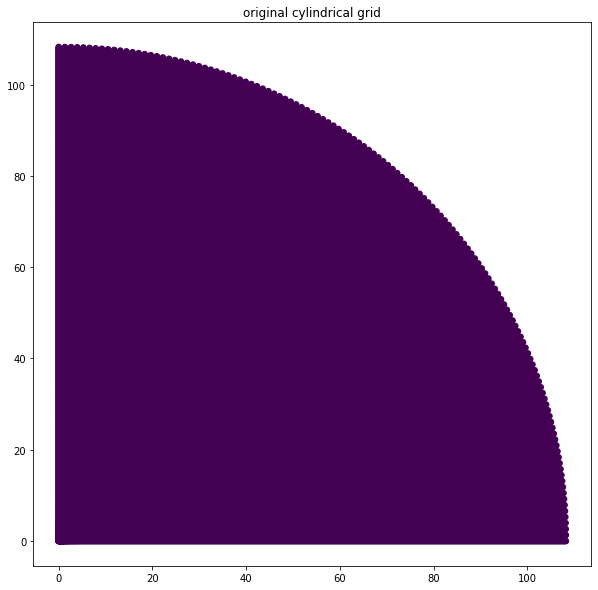

In [45]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x_cart[100],y_cart[100],s=30,c=ll[100])
plt.title('original cylindrical grid')

In [46]:
plt.close()
del fig

Create a new 2D grid, the same resolution as the original 2D image, to interpolate onto

In [47]:
#create new grid 2D to interpolate on
x_max = y_max = np.max(r)
grid_size = r[1]-r[0]
r_len = len(r)
#the spacing of the goal grid is the same as the original 2D cylindrical grid
x_ar = np.linspace(-(grid_size/2),x_max,r_len+1)[1:]
y_ar = np.linspace(-(grid_size/2),y_max,r_len+1)[1:]
grid_x, grid_y = np.meshgrid(x_ar,y_ar)

Text(0.5, 1.0, 'cartesian grid to interpolate on')

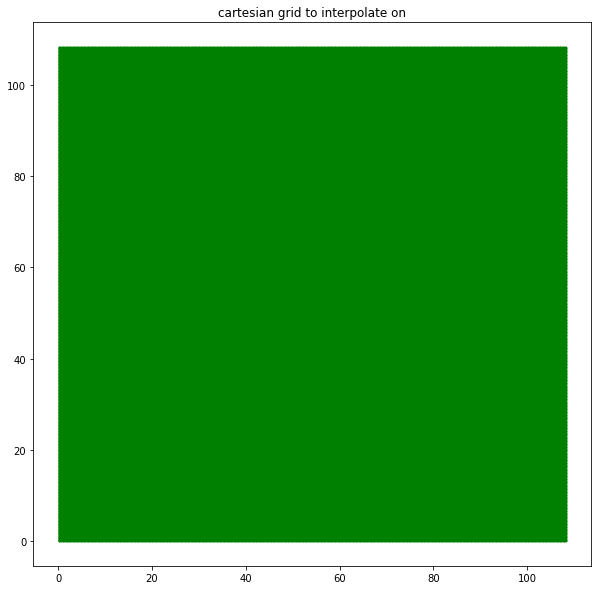

In [48]:
fig = plt.figure(figsize=(10,10))
plt.plot(grid_x,grid_y,'o',markersize=0.8,color='green')
plt.title('cartesian grid to interpolate on')

In [49]:
plt.close()
del fig

No run the interpolator over all slices of the frame:

Flatten and save the output of the interpolator, 
and integrate over all slices to return a 2D image:

In [50]:
def loader_bar(i,range,modulo): #just for output purposes
    perc = int((i/range)*100)
    prev_perc = int(((i-1)/range)*100)
    if i==0:
        s = str(0)+"%"
        print(s,end="...",flush=True)
    if perc%modulo==0 and perc!=prev_perc:
        s = str(perc)+"%"
        print(s,end="...",flush=True)
        prev_perc=perc+modulo

In [51]:
if save_or_load=='save':
    interps = []
    iter_num = len(z_ordered)
    for i in range(iter_num):
        loader_bar(i,iter_num,5)
        x_arr = x_cart[i].flatten() #160x130 points -> 20800
        y_arr = y_cart[i].flatten()
        points = (x_arr,y_arr)
        values = ll[i].flatten()
        interp_grid = (grid_x,grid_y)
        interp = griddata(points,values,interp_grid,method='linear')
        interps.append(interp)
    interp_clean = np.nan_to_num(interps) #remove all nans and turn them into zeros for the sake of integration 
    save_list(np.asarray(interp_clean),results_folder,'interpolated_frame_'+system_name+'_'+str(image_timestep))
    len(interp_clean)
    integrated_frames = []
    pixel_vol = (grid_size)**3 #multiply by the volume of each pixel when integrating
    for frame in interp_clean:
        integrated_frame = np.sum(frame,axis=0)*pixel_vol*2
        integrated_frames.append(integrated_frame)
    save_list(np.asarray(integrated_frames),results_folder,'integrated_frame_'+system_name+'_'+str(image_timestep))
elif save_or_load=='load':
    print("loading")
    interp_clean = load_list(results_folder,'interpolated_frame_'+system_name+'_'+str(image_timestep))
    integrated_frames = load_list(results_folder,'integrated_frame_'+system_name+'_'+str(image_timestep))

loading


Plot the output of theinterpolator for a single slice:

/Users/savard/opt/anaconda3/envs/lower_python_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


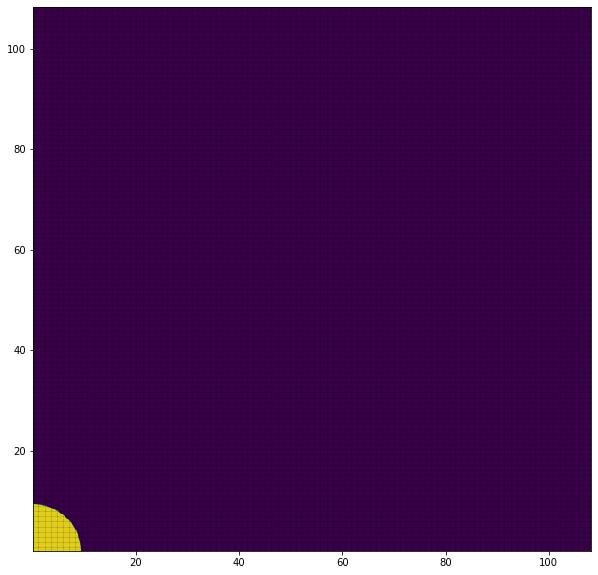

In [52]:
slice_index = 640
plt.figure(figsize=(10,10))
plt.pcolormesh(grid_x,grid_y,interp_clean[slice_index]*1e8,shading='flat')
plt.scatter(grid_x,grid_y,s=0.001,color='black')

Lots on NANs in the data are there because of extremely small values of emissivity due to the tracer, they can be essentailly replaced with zeroes. 

saving new figure!!


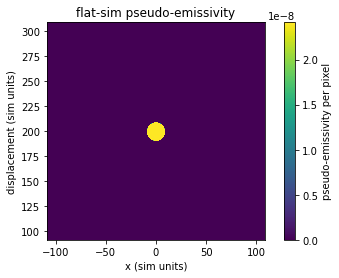

In [53]:
#psuedo emissivity
#trim = 1112

#psuedo emissivity
#trim = 1112
fsize = [7,4]

ax1 = D.x1[:stop_index_side]
ax2 = D.x2[stop_index_bottom:stop_index_top]
scale = len(ax2)/(len(ax1)*2)
plt.figure(figsize=fsize)
em = ((D.tr1*((kappa*D.prs)**exponent))[:stop_index_side].T[stop_index_bottom:stop_index_top]).T #psuedo emissivity, 2D array 

plt.pcolormesh(ax1,ax2,em.T,shading='auto')
plt.pcolormesh(-ax1,ax2,em.T,shading='auto')
#plt.pcolormesh(-ax1,ax2,var.T,shading='auto')
cbar = plt.colorbar()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.title('flat-sim pseudo-emissivity')
plt.xlabel('x (sim units)')
plt.ylabel('displacement (sim units)')
cbar.set_label('pseudo-emissivity per pixel')

save=True
name = 'flat_frame_'+system_name+'_'+str(image_timestep)
save_fig(results_folder,name,overwrite=save)

In [55]:
def loader_bar(i,range,modulo):
    perc = int((i/range)*100)
    prev_perc = int(((i-1)/range)*100)
    if i==0:
        s = str(0)+"%"
        print(s,end="...",flush=True)
    if perc%modulo==0 and perc!=prev_perc:
        s = str(perc)+"%"
        print(s,end="...",flush=True)
        prev_perc=perc+modulo



r = 1300
for i in range(r):
    loader_bar(i,r,5)

0%...5%...10%...15%...20%...25%...30%...35%...40%...45%...50%...55%...60%...65%...70%...75%...80%...85%...90%...95%...

saving new figure!!


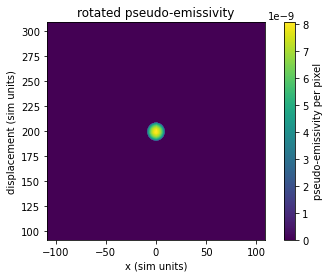

In [56]:


scale = len(ax2)/(len(ax1)*2)
plt.figure(figsize=fsize)
plt.pcolormesh(ax1,ax2,integrated_frames,shading='auto')
plt.pcolormesh(-ax1,ax2,integrated_frames,shading='auto')
cbar = plt.colorbar()

plt.title('rotated pseudo-emissivity')
plt.xlabel('x (sim units)')
plt.ylabel('displacement (sim units)')
cbar.set_label('pseudo-emissivity per pixel')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')


save = True

name = 'rotated_frame_'+system_name+'_'+str(image_timestep)
save_fig(results_folder,name,overwrite=save)

### Comparing with non-interpolated frames

Rotate each cell and integrate and compare the total luminosity:

In [57]:
interp_total_lum = np.sum(integrated_frames)
interp_total_lum*2

5.4930376628365964e-05

In [58]:
def image_to_lum(D):
    lum = np.empty(shape=(len(ax1),len(ax2)))
    grid_size=ax1[4]-ax1[3]
    for i, rad in enumerate(ax1):
        for j, y in enumerate(ax2):
            emis = em[i][j]
            lum[i][j] = emis*(2*np.pi*rad)*(grid_size**2)
    return lum


def image_to_lum_boost(D,viewing_angle,alpha,kappa):
    emis = em
    beta = (D.vx2[:stop_index_side].T[stop_index_bottom:stop_index_top]).T
    boosted_lum = doppler_boost_lum(beta,viewing_angle,alpha,emis)
    grid_size=ax1[4]-ax1[3]
    rad , z = np.meshgrid(ax1,ax2)
    lum = boosted_lum*2*np.pi*rad.T*(grid_size**2)
    return lum

In [59]:
non_interp_total_lum = np.sum(image_to_lum_boost(D,viewing_angle,alpha,kappa))
non_interp_total_lum

5.493022253009965e-05

### Convert to Janskys! 

Specify simulation units and desired observational frequency, also departure from equipartition

In [60]:
from pluto_luminosity_conversion import *

lum_real_unit = lum_unit_si(eta=0.75,P=P_sim,L=L_sim,nu=nu_observe, q=p) #W Hz^-1 sr^-1

In [61]:
lum_sim = np.asarray(integrated_frames)
lum_true = lum_sim*lum_real_unit # W Hz^-1 sr^-1
lum_jansky = lum_true*(10**26)*np.pi*4 # 10^26 W Hz^-1  -> 10^-26 W m^-2 Hz^-1 = 1 jansky 

distance = distance_in_pc*3.086*(10**16) # convert parsec to m 

lum_jansky_far = np.asarray(lum_jansky / (4*np.pi*(distance**2)),dtype='float64')
boosted_lum = lum_jansky_far
save_list(boosted_lum,results_folder,'pixel_lum_'+system_name+'_'+str(image_timestep)+'_'+str(nu_observe/(1e9))+str('GHz'))


Total integrated luminosity:

~85% resolved out flux density at 1.7mJy from observations at zeroth timestep 

In [ ]:
etot = 4e44
delta_t 

In [62]:
frame_flux = np.sum((boosted_lum*10**3))*2
print('total luminosity in frame in mJy: '+str(frame_flux))

total luminosity in frame in mJy: 2.0563410839586975


In [63]:
dtype='flt'

def image_to_lum(D,viewing_angle,alpha,kappa,boost=True):
    """calculates psudo emissivity of a simulation frame, and applies doppler boosting (if boost=True).
    the emissivity is then rotated and integrated to get a total emissivity of a frame in 3D.
    return a value of total emission in frame. 
    """
    emis = D.tr1*((kappa*(D.prs))**exponent)
    beta = D.vx2
    if boost:
        boosted_lum = doppler_boost_lum(beta,viewing_angle,alpha,emis)
    else:
        boosted_lum = emis
    grid_area = (D.x1[4]-D.x1[3])*(D.x2[4]-D.x2[3])
    rad , z = np.meshgrid(D.x1,D.x2) #format radius matrix to quickly multiply
    lum = boosted_lum*2*np.pi*rad.T*(grid_area) #rotate and integrate luminosity in cylindrical coords
    return lum

def total_lums(data_dir,viewing_angle,alpha,kappa,boost=True,first=False):
    """for each frame of a simulation, calculate the total emissivity per frame (doppler boosted
    if boost=True)
    """
    if first:
        max_step = 1
    else:
        max_step = get_max_step(data_dir)
    total_lums = []
    for i in range(max_step+1):
        D = load_data_obj(data_dir,i,data_type=dtype)
        lum = image_to_lum(D,viewing_angle,alpha,kappa,boost)
        total_lums.append(np.sum(lum))
    return total_lums

def lum_sim_to_jansky(lum,distance_in_pc):
    """converts from emissivity to janskys given some constant simulation units
    """
    P_SIM = 1.503*10**(-4) #in kg m^-1 s^2
    L_SIM = 1*10**13 #in meters
    NU_OBS = (1.28 * 1e9) #1.28 GHz (Bright2020)
    ETA = 0.75 #equipartition
    distance = distance_in_pc*3.086*(10**16) # convert parsec to m 
    print(distance_in_pc)

    lum_real_unit = lum_unit_si(eta=ETA,P=P_SIM,L=L_SIM,nu=NU_OBS,q=p) #W Hz^-1 sr^-1
    lum_true = np.asarray(lum)*lum_real_unit # W Hz^-1 sr^-1
    lum_jansky = lum_true*(10**26)*np.pi*4 # 10^-26 W Hz^-1, get rid of sr^-1 -> 10^-26 W m^-2 Hz^-1 = 1 jansky 
    lum_jansky_far = np.asarray(lum_jansky / (4*np.pi*(distance**2)),dtype='float64') #10^-26 W Hz^-1 m^-2
    return lum_jansky_far

lum1 = total_lums(data_dir,viewing_angle,alpha,kappa,boost=True,first=True)
print(lum1)
lum_jansky1 = lum_sim_to_jansky(lum1,distance_in_pc) #convert to janskys 

print("Initial lum: "+str(lum_jansky1[0]*10**3)+" mJy")

data type: flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/rho.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/vx1.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/vx2.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/vx3.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/prs.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/tr1.0000.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/tr2.0000.flt
data type: flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/rho.0001.flt
Reading multiple variable files : /Users/savard/PLUTO/plut

Plot luminosity in mJy:

In [64]:
def m_to_arcseconds(m):
    acs = (m*100)/(1.496*10**(13))*(1/distance_in_pc)
    return acs

Overwriting existing figure!!!


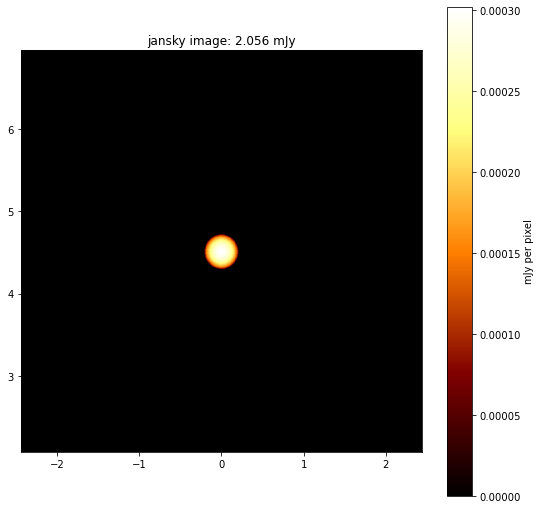

In [65]:

x = m_to_arcseconds(ax1*L_sim)
y = m_to_arcseconds(ax2*L_sim)

scale = len(ax2)/(len(ax1)*2)
plt.figure(figsize=[9*scale,9])
plt.pcolormesh(x,y,(boosted_lum*10**3),cmap='afmhot',shading='auto')
plt.pcolormesh(-x,y,(boosted_lum*10**3),cmap='afmhot',shading='auto')
cbar = plt.colorbar()
cbar.set_label('mJy per pixel')

plt.title('jansky image: {:.3f} mJy'.format(frame_flux))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
save = True

name = 'radio_frame_'+system_name+'_'+str(image_timestep)+'_'+str(nu_observe/(1e9))+str('GHz')
save_fig(results_folder,name,overwrite=save)

In [136]:
np.shape((boosted_lum*10**3))

(1300, 650)

In [137]:
np.shape(y)

(1300,)

## EZ-BLOB oven

In [92]:
from astropy.io import fits

In [93]:
ez_filename = 'pixel_lum_'+system_name+'_'+str(image_timestep)+'_'+str(nu_observe/1e9)+'GHz'
image_array = load_list(results_folder,ez_filename)
image_array_flip = np.concatenate((np.flip(image_array,axis=1),np.array(image_array)),axis=1)

In [94]:
#put this into wsclean command

np.shape(image_array_flip)

(1300, 1300)

In [95]:
#if it needs reshaping for wsclean (odd numbers)

def adjust(image_array,axis='row'): #adds on an extra row
    if axis=='row':
        z = [0]*(len(image_array.T))
        new_image = np.row_stack([z,image_array])
    elif axis=='column':
        z = [0]*(len(image_array))
        new_image = np.column_stack([z,image_array])
    return new_image

#if its higher resolution on one axis (to make pixels square)
def deres_array(image_array,res,axis='row'): #remove every x=res rows from array
    new_lum_array = []
    if axis=='row':
        for index, row in enumerate(image_array):
            if index%res==1:
                new_lum_array.append(row)
    elif axis=='column':
        for index, column in enumerate(image_array.T):
            if index%res==1:
                new_lum_array.append(column)

    return new_lum_array

In [96]:
def deres_array_check(image):
    #check if needs a deres
    column_resolution = image[1][5]-image[1][4]
    row_resolution = image[5][1]-image[4][1]
    if row_resolution==column_resolution:
        print('square elements, no need to de-res')
        print('Shape: '+str(np.shape(image)))
    else:
        if row_resolution>column_resolution:
            print('deres row')
            resolution_difference = row_resolution/column_resolution
            image = np.array(deres_array(image,resolution_difference),axis='row')
            print('New shape: '+str(np.shape(image)))
        else:
            print('deres column')
            resolution_difference = column_resolution/row_resolution
            image = np.array(deres_array(image,resolution_difference),axis='column')
            print('New shape: '+str(np.shape(image)))
    return image

In [97]:
def even_shape_check(image):
    row_len = len(image[0])
    column_len = len(image.T[0])
    even = True
    print(row_len)
    print(column_len)
    print(row_len%2)
    print(column_len%2)
    if row_len%2==1:
        even=False
        print('adding another column')
        image = adjust(image,axis='column')
    if column_len%2==1:
        even=False
        print('adding another row')
        image = adjust(image,axis='row') 
    if even:
        print("image has even sides, no need to adjust")
    return image

In [98]:
print(np.shape(image_array_flip))
#check if needs a deres
image_array_flip = deres_array_check(image_array_flip)

#check if the shape is even
image_array_flip = even_shape_check(image_array_flip)

print(np.shape(image_array_flip))

(1300, 1300)
square elements, no need to de-res
Shape: (1300, 1300)
1300
1300
0
0
image has even sides, no need to adjust
(1300, 1300)


In [99]:
hdu = fits.PrimaryHDU(image_array_flip)
fits_name = 'ffile_'+system_name+'_'+str(image_timestep)+'_'+str(nu_observe/1e9)+'GHz'

exta_descriptors=''

save_to = results_folder+'/'+fits_name+exta_descriptors+'.fits'
hdu.writeto(save_to,overwrite=True)

In [100]:
def unit_print(D,image):
    #now check what the resolution size is in real units for wsclean:
    ax1_check = D.x1[:len(image[0])]
    ax2_check = D.x2[:len(image.T[0])]
    x = m_to_arcseconds(ax1_check*L_sim)
    y = m_to_arcseconds(ax2_check*L_sim)

    print('x-direction res: {:.4f} arcseconds'.format(x[2]-x[1]))
    print('y-direction res: {:.4f} arcseconds'.format(y[2]-y[1]))

In [101]:
unit_print(D,image_array)

x-direction res: 0.0038 arcseconds
y-direction res: 0.0038 arcseconds


wsclean -size 800 602 -scale 0.01asec -niter 0 -channels-out 1 -name prediction -data-column DATA -use-wgridder -mem 50 targetdata.ms

wsclean -predict -mem 50 -size 602 800 -scale 0.01asec -channels-out 1 -name prediction -use-wgridder targetdata.ms/

In [102]:
np.shape(boosted_lum.T[0])

(1300,)

In [103]:
len(ax1)

650

In [104]:
xx1 = D.x1[:np.shape(image_array[0])]

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
def print_and_save(string,output):
    print(string)
    output+=string
    return output


In [ ]:
output = ''
image_timestep=2
output = print_and_save(" Image timestep = "+str(image_timestep)+"\n System = "+system_name,output)

 Image timestep = 2
 System = ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2


In [ ]:
print(output)


 Image timestep = 2
 System = ri0.001_rb0.02_k0.1_lz25_6hhres_newprs2
